The goal here is to calculate the overlap of the baseline footprint vs. BigWFD footprint with DESI. We calculate the overlap area + the median depth in the different bands in the overlap region.

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
# need some routines developed for LSSTDESC/ObsStrat/
import sys
sys.path.insert(0, '/global/homes/a/awan/LSST/lsstRepos/ObsStrat/code/modifyWFD/')
import helpers

# lets just ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up**

In [3]:
fids_file = 'field_list.csv'   # in this repo
outdir = '/global/cscratch1/sd/awan/lsst_output/moar_area_output/'

# data dir for DESI footprint
# saved by the notebooks in LSSTDESC/ObStrat/static/depth_cuts/overlaps
footprint_dir = '/global/homes/a/awan/desc/4most-tides_desi_data/'

# path + tags to read in coadd data for the dbs; saved data has masks for each band.
file_yearTag = 'fullSurveyPeriod'
coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_noDith/'

bands = ['u', 'g', 'r', 'i', 'z', 'y']

**Read in the fields list**

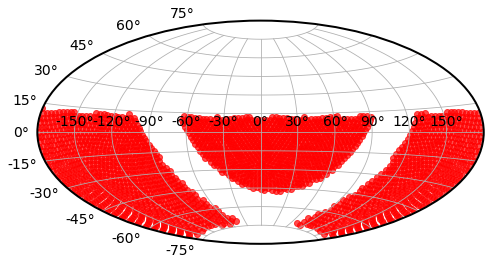

In [4]:
# Read the field list.
fields = pd.read_csv(fids_file)
# Select fields with declination between -90 and 32 -- our "big sky" footprint
wfd = fields.query('(dec >= -72.25) and (dec <= 12.4) and ((gb >= 15) or (gb <= -15))')

# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="aitoff")
x, y = radec2project(wfd.ra, wfd.dec)
ax.scatter(x, y, alpha=0.7, color='r')
plt.grid(True)
plt.show()

**Read in the mapping between fieldIds and HEALPix pixels (saved by get_fov_pixels)**

In [5]:
file = [f for f in os.listdir(outdir) if f.endswith('.pickle') and f.__contains__('und')][0]
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
pix_fov_dict = pickle.load(open('%s/%s'%(outdir, file), "rb"))
pix_fov_dict.pop('meta')

# get the healpix pixels for all the fieldsIDs in BigWFD
pix_list = []
for fid in wfd.fieldId:
    pix_list += pix_fov_dict[fid]
pix_list = np.unique(pix_list)

# save the pixel list
footprint_pixels = {}
footprint_pixels['BigWFD'] = pix_list

Reading in pixels_in_fov_undithered_nside256.pickle:
Nside: 256


**Read in the DESI footprint**

In [6]:
key = 'DESI'
# read in the DESI footprints 
for i, file in enumerate([f for f in os.listdir(footprint_dir) if f.startswith(key)]):
    if i>0: raise ValueError('Somethings wrong.')
    print('Reading %s'%file)
    print('nside: %s'%int(file.split('nside')[-1].split('_')[0]))
    footprint_pixels[key] = pd.read_csv('%s/%s'%(footprint_dir, file))['pixNum'].values

Reading DESI_pixels_nside256_ring.csv
nside: 256


**Read in the baseline2018a coadd data to find all-band footprint**

In [7]:
dbname = 'baseline2018a'
# Read in the coadd data for the db
data_bundle = {}   
for band in bands:
    # set up the folders
    folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
    folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
    path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
    # get the filenames
    filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
    print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

    if len(filenames)>1:
        err = 'Have more than one npz file for %s band'%band
        err += ' for %s data: %s'%(yr_cut, filenames)
        raise ValueError(err)
    else:
        dither = filenames[0].split('%s_'%band)[-1]
        dither = dither.split('.npz')[0]
        mB = metricBundles.createEmptyMetricBundle()
        mB.read('%s/%s'%(path, filenames[0]))
        data_bundle['%s'%(band)]= mB

# find all-band footprint
all_band_pixels = None

for band in data_bundle:
    index = np.where((data_bundle[band].metricValues.mask == False) & \
                     (data_bundle[band].metricValues.data > 0))[0]
    # save the indices
    if all_band_pixels is None:
        # initate the list
        all_band_pixels = index
    else:
        # keep only the overlapping pixels
        all_band_pixels = list(set(all_band_pixels).intersection(index))

footprint_pixels['all-band %s'%dbname] = np.array(all_band_pixels)

Reading ['coaddM5Data_unmasked_u_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using

**Lets plot all the footprints that we have so far**

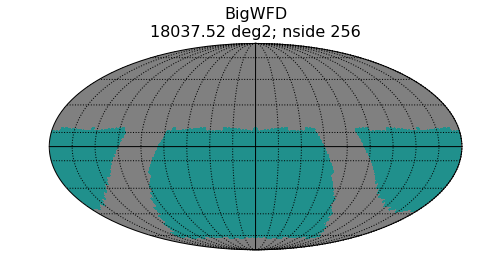

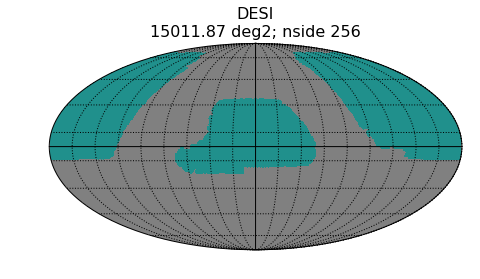

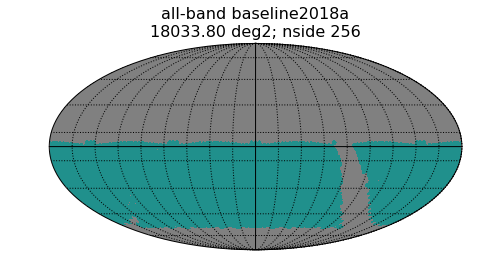

In [8]:
for key in footprint_pixels:
    helpers.plot_skymap_somepix(pix_list=footprint_pixels[key], nside=nside, title_append=key)

**Lets plot the figure with all the overlaps**

DESI: -19.79 <= dec <= 76.45
all-band baseline2018a: -63.64 <= dec <= 4.33
BigWFD: -73.68 <= dec <= 14.02

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved bigwfd_vs_baseline2018a_vs_DESI_nside256_matplotlib.png


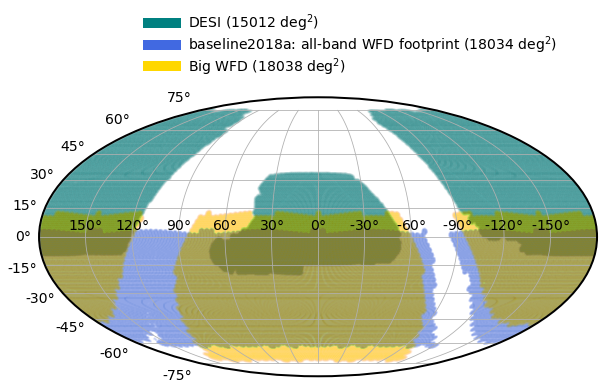

In [9]:
order_list = ['DESI', 'all-band %s'%dbname, 'BigWFD']
order_dict = {}
for key in order_list:
    order_dict[key]= footprint_pixels[key]
    
colors = ['teal', 'royalblue', 'gold']

alphas = [0.02, 0.03, 0.01]
titles = ['DESI', '%s: all-band WFD footprint'%dbname, 'Big WFD']

filename = 'bigwfd_vs_%s_vs_DESI_nside%s_matplotlib.png'%(dbname, nside)
filename = '%s%s'%(outdir, filename)
helpers.plot_matplot(nside=nside, pixels_dict=order_dict, syms=['x', '_', 'o'],
                     colors=colors, alphas=alphas, titles=titles,
                     saveplot=True, fname=filename)

**Lets calculate the area overlap with DESI with baseline footprint + the BigWFD, and median coadded depth in the overlaps**

First need to read in the coadd data. must use pontus_2002 for BigWFD since baseline2018a doesnt cover all the area we're looking at. For comparison between between baseline2018a and pontus_2002, we can look at the median depth between the two.

In [10]:
# read in the coadd data
coadd_bundles = {}
for dbname in ['baseline2018a', 'pontus_2002']:
    # Read in the coadd data for the kraken_2026
    data_bundle = {}   
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        # set up the folders
        folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
        folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
        path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
        # get the filenames
        filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
        print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

        if len(filenames)>1:
            err = 'Have more than one npz file for %s band'%band
            err += ' for %s data: %s'%(yr_cut, filenames)
            raise ValueError(err)
        else:
            dither = filenames[0].split('%s_'%band)[-1]
            dither = dither.split('.npz')[0]
            mB = metricBundles.createEmptyMetricBundle()
            mB.read('%s/%s'%(path, filenames[0]))
            data_bundle['%s'%(band)]= mB

    coadd_bundles[dbname] = data_bundle

Reading ['coaddM5Data_unmasked_u_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using

**Lets calculate the overlap area, the median depth in the overlap area (using pontus_2002), and the median depth in baseline2018a vs. pontus2002**

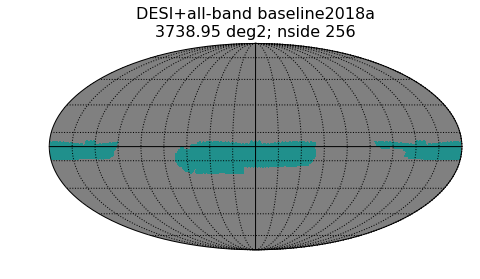

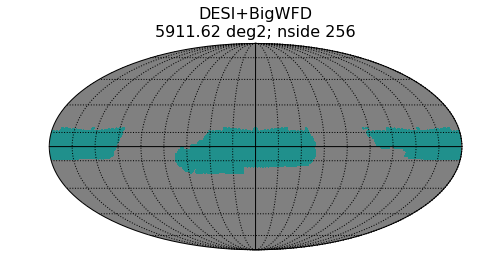

In [11]:
overlap_area = {}
median_depth = {}
for key in ['all-band baseline2018a', 'BigWFD']:
    # find the overlapping pixels
    overlap = list( set(footprint_pixels['DESI'])- \
                   ( set(footprint_pixels['DESI'])- set(footprint_pixels[key])
                   )
                  )
    # calculate the area in the overlapping pixels and save it
    overlap_area['DESI+%s'%key] = helpers.get_area(pix_arr=overlap, nside=nside)
    # plot to check things
    helpers.plot_skymap_somepix(pix_list=overlap, nside=nside, title_append='DESI+%s'%key)

    # now calculate the median depth
    db = 'pontus_2002'
    median_depth['DESI+%s'%(key)] = {}
    for band in bands:
        median_depth['DESI+%s'%(key)][band] = np.median(coadd_bundles[db][band].metricValues.data[overlap])

# calculate the median depth across the WFD for dbs
for db in coadd_bundles:
    median_depth[db] = {}
    for band in bands:
        ind = np.where(coadd_bundles[db][band].metricValues.mask == False)[0]
        median_depth[db][band] = np.median(coadd_bundles[db][band].metricValues.data[ind])

Lets read in the saved data in a way to output two md tables: 
- for the overlaps and median depths therein and
- for the median depths in pontus2002 vs. baseline2018a

In [12]:
# first the overlaps + median depth
header = '| footprint | '
header2 = '| ------ | '

for i, key in enumerate(['all-band baseline2018a', 'BigWFD']):
    row = ' | %s | '%key
    header += ' DESI overlap (deg2) | '
    header2 += ' ------ | '
    row += '  %.f | '%overlap_area['DESI+%s'%(key)] 
    # now look at the median depth
    db = 'pontus_2002'
    for band in median_depth['DESI+%s'%(key)]:
        header += ' Median %s %s-band depth (with dust extinction) in overlap| '%(db, band)
        header2 += ' ------ | '
        row += '  %.2f | '%median_depth['DESI+%s'%(key)][band]   
    if i==0:
        print('%s\n%s'%(header, header2))
    print(row)
    
# now the median depth in the WFD region for the two fbs
header = '\n\n| Median 5$\sigma$ Coadded Depth (with dust extinction) in WFD | '
header2 = '| ------ | '
for i, band in enumerate(median_depth[db]):
    row = '| %s-band  | '%band
    for db in coadd_bundles:     
        header += ' %s | '%(db)
        header2 += ' ------ | '
        row += '  %.2f | '%median_depth[db][band]

    if i==0:
        print('%s\n%s'%(header, header2))
    print(row)

| footprint |  DESI overlap (deg2) |  Median pontus_2002 u-band depth (with dust extinction) in overlap|  Median pontus_2002 g-band depth (with dust extinction) in overlap|  Median pontus_2002 r-band depth (with dust extinction) in overlap|  Median pontus_2002 i-band depth (with dust extinction) in overlap|  Median pontus_2002 z-band depth (with dust extinction) in overlap|  Median pontus_2002 y-band depth (with dust extinction) in overlap| 
| ------ |  ------ |  ------ |  ------ |  ------ |  ------ |  ------ |  ------ | 
 | all-band baseline2018a |   3739 |   25.21 |   26.73 |   26.83 |   26.33 |   25.45 |   24.64 | 
 | BigWFD |   5912 |   25.15 |   26.68 |   26.79 |   26.29 |   25.41 |   24.60 | 


| Median 5$\sigma$ Coadded Depth (with dust extinction) in WFD |  baseline2018a |  pontus_2002 | 
| ------ |  ------ |  ------ | 
| u-band  |   25.30 |   25.02 | 
| g-band  |   26.84 |   26.59 | 
| r-band  |   26.98 |   26.75 | 
| i-band  |   26.46 |   26.24 | 
| z-band  |   25.57 |   25.4

| footprint |  DESI overlap (deg2) |  Median pontus_2002 u-band depth (with dust extinction) in overlap|  Median pontus_2002 g-band depth (with dust extinction) in overlap|  Median pontus_2002 r-band depth (with dust extinction) in overlap|  Median pontus_2002 i-band depth (with dust extinction) in overlap|  Median pontus_2002 z-band depth (with dust extinction) in overlap|  Median pontus_2002 y-band depth (with dust extinction) in overlap| 
| ------ |  ------ |  ------ |  ------ |  ------ |  ------ |  ------ |  ------ | 
 | all-band baseline2018a |   3739 |   25.21 |   26.73 |   26.83 |   26.33 |   25.45 |   24.64 | 
 | BigWFD |   5912 |   25.15 |   26.68 |   26.79 |   26.29 |   25.41 |   24.60 | 


| Median 5$\sigma$ Coadded Depth (with dust extinction) in WFD |  baseline2018a |  pontus_2002 | 
| ------ |  ------ |  ------ | 
| u-band  |   25.30 |   25.02 | 
| g-band  |   26.84 |   26.59 | 
| r-band  |   26.98 |   26.75 | 
| i-band  |   26.46 |   26.24 | 
| z-band  |   25.57 |   25.40 | 
| y-band  |   24.79 |   24.60 | 